# Cactus Identification

#### https://www.kaggle.com/c/aerial-cactus-identification/overview
To assess the impact of climate change on Earth's flora and fauna, it is vital to quantify how human activities such as logging, mining, and agriculture are impacting our protected natural areas. Researchers in Mexico have created the VIGIA project, which aims to build a system for autonomous surveillance of protected areas. A first step in such an effort is the ability to recognize the vegetation inside the protected areas. In this competition, you are tasked with creation of an algorithm that can identify a specific type of cactus in aerial imagery.

In [1]:
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
import os, os.path
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,confusion_matrix,auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Data Preperation

In [2]:
   
imgs_test = []
i=0
path = "test"
valid_images = [".jpg"]
listing = os.listdir(path)
for i in range(0,len(listing),200):
    for f in listing[i:i+200]:
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        m =os.path.join(path,f)
        m = Image.open(m)
        n= np.array(m)
        imgs_test.append(n)
        m.close()

In [3]:
imgs_train = []
i=0
path = "train"
valid_images = [".jpg"]
listing = os.listdir(path)
for i in range(0,len(listing),200):
    for f in listing[i:i+200]:
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        m =os.path.join(path,f)
        m = Image.open(m)
        n= np.array(m)
        imgs_train.append(n)
        m.close()

In [4]:
label_train = pd.read_csv("train.csv")
train_labels= label_train["has_cactus"]
train_id = label_train['id']
print(label_train.head())

                                     id  has_cactus
0  0004be2cfeaba1c0361d39e2b000257b.jpg           1
1  000c8a36845c0208e833c79c1bffedd1.jpg           1
2  000d1e9a533f62e55c289303b072733d.jpg           1
3  0011485b40695e9138e92d0b3fb55128.jpg           1
4  0014d7a11e90b62848904c1418fc8cf2.jpg           1


In [5]:
print(train_labels.value_counts())

1    13136
0     4364
Name: has_cactus, dtype: int64



This shows that this is an imbalanced dataset 

In [6]:
imgs_train = np.asarray(imgs_train)
imgs_train_new  = imgs_train.reshape(17500,3072)

1


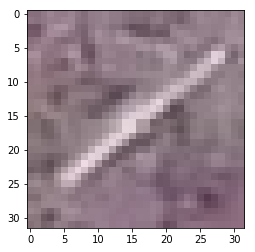

In [14]:
plt.imshow(imgs_train[0], interpolation='nearest')
print(train_labels[0])
plt.show()


In [15]:
print(imgs_train.shape)

(17500, 32, 32, 3)


### TSNE PLOT

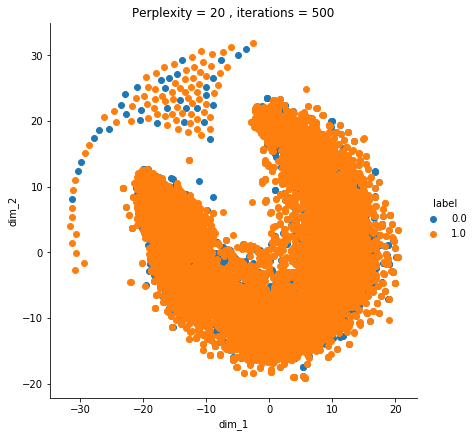

In [107]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

model = TSNE(n_components=2,perplexity=20,n_iter=500,random_state=0) 
# converting sparse to a dense array
final_count= X_tr
# standardizing our data making mean=0 and std_dev=1
standardize = StandardScaler().fit_transform(final_count)
_data = model.fit_transform(standardize)
#creating a new data which help us in plotting the result data
_data = np.vstack((_data.T,y_tr)).T
_df = pd.DataFrame(data = _data,columns=("dim_1","dim_2","label"))
# Plotting the result of tsne
sns.FacetGrid(_df,hue="label",size=6).map(plt.scatter,"dim_1","dim_2").add_legend()
plt.title('Perplexity = 20 , iterations = 500')
plt.show() 

In [7]:
X_1, X_test, y_1, y_test = cross_validation.train_test_split(imgs_train_new,train_labels, test_size=0.2, random_state=0) 
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.2)

In [8]:
print(np.asarray(X_1).shape,np.asarray(X_test).shape,np.asarray(X_tr).shape,np.asarray(X_test).shape,np.asarray(X_cv).shape)

(14000, 3072) (3500, 3072) (11200, 3072) (3500, 3072) (2800, 3072)


### K-nearest_neihbourr

In [44]:
train_accuracy = []
cv_accuracy = []
k=[1, 5, 10, 15, 21, 31, 41, 51]
for i in k:
    Knn = KNeighborsClassifier(n_neighbors=i)
    Knn.fit(X_tr,y_tr)
    train_pred = []
    valid_pred = []
    for i in range(0, X_tr.shape[0], 1000):
        train_pred.extend(Knn.predict_proba(X_tr[i:i+1000])[:,1])
    for i in range(0, X_cv.shape[0], 1000):
        valid_pred.extend(Knn.predict_proba(X_cv[i:i+1000])[:,1])
    
    train_accuracy.append(roc_auc_score(y_tr,train_pred))
    cv_accuracy.append(roc_auc_score(y_cv,valid_pred))
    print(i)





2000
2000
2000
2000
2000
2000
2000
2000


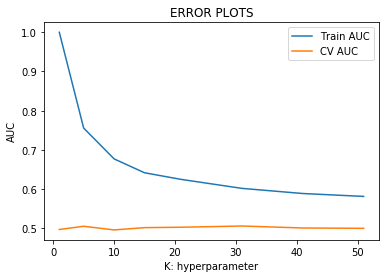

In [47]:
plt.plot(k, train_accuracy, label='Train AUC')
plt.plot(k, cv_accuracy, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [48]:
best_k = 21

### Testing with test data

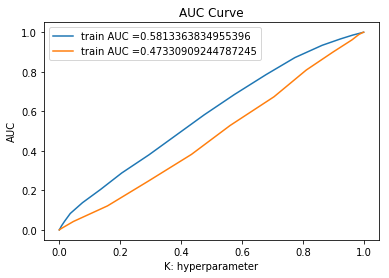

In [50]:
Knn = KNeighborsClassifier(n_neighbors=best_k)
Knn.fit(X_tr,y_tr)
test_pred = []
for i in range(0, X_test.shape[0], 1000):
        test_pred.extend(Knn.predict_proba(X_test[i:i+1000])[:,1])
train_fpr, train_tpr, thresholds = roc_curve(y_tr, train_pred)
test_fpr, test_tpr, thresholds = roc_curve(y_test, test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC Curve")
plt.show()

### Confusion Matrix

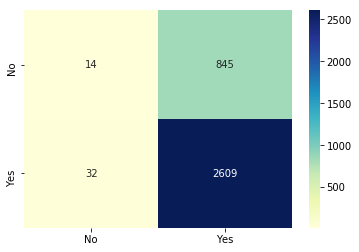

In [57]:
ytrain = model.predict(BOW_Train)
ytest = model.predict(BOW_test)
ctrain = confusion_matrix(y_tr,ytrain)
ctest = confusion_matrix(y_test,ytest)
class_label=["No","Yes"]
df = pd.DataFrame(ctest, index=class_label, columns=class_label)
sns.heatmap(df, annot= True, fmt="d", cmap="YlGnBu")


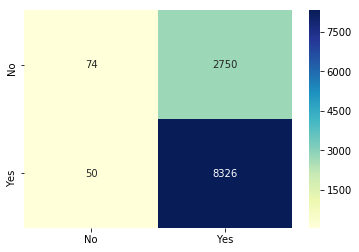

In [58]:
df = pd.DataFrame(ctrain, index=class_label, columns=class_label)
sns.heatmap(df, annot= True, fmt="d", cmap="YlGnBu")

### Linear SVM Using L1 regularizer 

0.0001
0.001
0.01
0.1
1
10
100
1000
10000


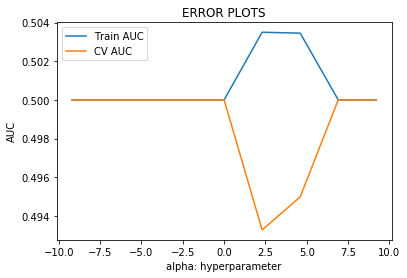

In [67]:
lamda= [10**(-4),10**(-3),10**(-2),10**(-1),1,10,100,1000,10000]
val_accuracy = []
train_accuracy = []
for i in lamda:
    model = SGDClassifier(penalty='l1',alpha=i)
    model.fit(X_tr,y_tr)
    model1 = CalibratedClassifierCV(model)
    model1.fit(X_tr,y_tr)
    val_data  = model1.predict_proba(X_cv)[:,1]
    train_data = model1.predict_proba(X_tr)[:,1]
    val_accuracy.append(roc_auc_score(np.asarray(y_cv),np.asarray(val_data)))
    train_accuracy.append(roc_auc_score(np.asarray(y_tr),np.asarray(train_data)))
    print(i)
plt.plot(np.log(np.asarray(lamda)), train_accuracy, label='Train AUC')
plt.plot(np.log(np.asarray(lamda)), val_accuracy, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
    
    

### Liner SVM using l2 regularizer

0.0001
0.001
0.01
0.1
1
10
100
1000
10000


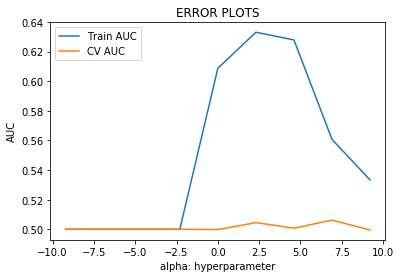

In [68]:
lamda= [10**(-4),10**(-3),10**(-2),10**(-1),1,10,100,1000,10000]
val_accuracy = []
train_accuracy = []
for i in lamda:
    model = SGDClassifier(penalty='l2',alpha=i)
    model.fit(X_tr,y_tr)
    model1 = CalibratedClassifierCV(model)
    model1.fit(X_tr,y_tr)
    val_data  = model1.predict_proba(X_cv)[:,1]
    train_data = model1.predict_proba(X_tr)[:,1]
    val_accuracy.append(roc_auc_score(np.asarray(y_cv),np.asarray(val_data)))
    train_accuracy.append(roc_auc_score(np.asarray(y_tr),np.asarray(train_data)))
    print(i)
plt.plot(np.log(np.asarray(lamda)), train_accuracy, label='Train AUC')
plt.plot(np.log(np.asarray(lamda)), val_accuracy, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
    
    

From above models we can say that simple machine larning models .arenot good fo classifying
images so we hould try advanced stuff like deep learning 

## Deep learrning MLP

In [53]:
from keras.models import Sequential 
from keras.layers import Dense, Activation 
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization
from keras.initializers import RandomNormal
from keras.layers import Dropout

In [54]:
Y_train = np_utils.to_categorical(y_tr, 2) 
Y_test = np_utils.to_categorical(y_test,2)
Y_cv = np_utils.to_categorical(y_cv,2)

print("After converting the output into a vector : ",Y_train[0])

After converting the output into a vector :  [1. 0.]


In [77]:
ou_dim=2
input_dim = 3072
batch_size = 1000
epoch = 12

In [78]:
model = Sequential()
model.add(Dense(3000,activation='sigmoid',input_shape=(input_dim,)))
model.add(Dense(2000,activation='sigmoid'))
model.add(Dense(1500,activation='sigmoid'))
model.add(Dense(1000,activation='sigmoid'))
model.add(Dense(240,activation='sigmoid'))
model.add(Dense(120,activation='sigmoid'))
model.add(Dense(10,activation='sigmoid'))
model.add(Dense(ou_dim,activation = 'softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 3000)              9219000   
_________________________________________________________________
dense_18 (Dense)             (None, 2000)              6002000   
_________________________________________________________________
dense_19 (Dense)             (None, 1500)              3001500   
_________________________________________________________________
dense_20 (Dense)             (None, 1000)              1501000   
_________________________________________________________________
dense_21 (Dense)             (None, 240)               240240    
_________________________________________________________________
dense_22 (Dense)             (None, 120)               28920     
_________________________________________________________________
dense_23 (Dense)             (None, 10)                1210      
__________

In [80]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(np.asarray(X_tr), Y_train, batch_size=batch_size, epochs=epoch, verbose=1, validation_data=(np.asarray(X_test), Y_test))

Train on 11200 samples, validate on 3500 samples
Epoch 1/12
11200/11200 [==============================] - 7s 589us/step - loss: 0.5648 - acc: 0.7479 - val_loss: 0.5573 - val_acc: 0.7546
Epoch 2/12
11200/11200 [==============================] - 3s 244us/step - loss: 0.5647 - acc: 0.7479 - val_loss: 0.5573 - val_acc: 0.7546
Epoch 3/12
11200/11200 [==============================] - 3s 241us/step - loss: 0.5647 - acc: 0.7479 - val_loss: 0.5573 - val_acc: 0.7546
Epoch 4/12
11200/11200 [==============================] - 3s 244us/step - loss: 0.5647 - acc: 0.7479 - val_loss: 0.5573 - val_acc: 0.7546
Epoch 5/12
11200/11200 [==============================] - 3s 246us/step - loss: 0.5647 - acc: 0.7479 - val_loss: 0.5573 - val_acc: 0.7546
Epoch 6/12
11200/11200 [==============================] - 3s 242us/step - loss: 0.5647 - acc: 0.7479 - val_loss: 0.5574 - val_acc: 0.7546
Epoch 7/12
11200/11200 [==============================] - 3s 246us/step - loss: 0.5647 - acc: 0.7479 - val_loss: 0.5574 - v

Test score: 0.5550559568405151
Test accuracy: 0.7567857142857143


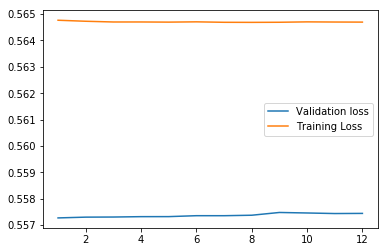

In [81]:
score = model.evaluate(X_cv, Y_cv, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])
vy = hist.history['val_loss']
ty = hist.history['loss']
x = list(range(1,epoch+1))
plt.plot(x,vy,label = 'Validation loss')
plt.plot(x,ty,label="Training Loss")
plt.legend()
plt.show()

In [82]:
model = Sequential()
model.add(Dense(3000,activation='sigmoid',input_shape=(input_dim,)))
model.add(Dense(2000,activation='relu'))
model.add(Dense(1500,activation='relu'))
model.add(Dense(1000,activation='relu'))
model.add(Dense(240,activation='relu'))
model.add(Dense(120,activation='relu'))
model.add(Dense(10,activation='sigmoid'))
model.add(Dense(ou_dim,activation = 'softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 3000)              9219000   
_________________________________________________________________
dense_26 (Dense)             (None, 2000)              6002000   
_________________________________________________________________
dense_27 (Dense)             (None, 1500)              3001500   
_________________________________________________________________
dense_28 (Dense)             (None, 1000)              1501000   
_________________________________________________________________
dense_29 (Dense)             (None, 240)               240240    
_________________________________________________________________
dense_30 (Dense)             (None, 120)               28920     
_________________________________________________________________
dense_31 (Dense)             (None, 10)                1210      
__________

In [83]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(np.asarray(X_tr), Y_train, batch_size=batch_size, epochs=epoch, verbose=1, validation_data=(np.asarray(X_test), Y_test))

Train on 11200 samples, validate on 3500 samples
Epoch 1/12
11200/11200 [==============================] - 4s 334us/step - loss: 0.5652 - acc: 0.7479 - val_loss: 0.5572 - val_acc: 0.7546
Epoch 2/12
11200/11200 [==============================] - 3s 242us/step - loss: 0.5636 - acc: 0.7479 - val_loss: 0.5577 - val_acc: 0.7546
Epoch 3/12
11200/11200 [==============================] - 3s 250us/step - loss: 0.5632 - acc: 0.7479 - val_loss: 0.5575 - val_acc: 0.7546
Epoch 4/12
11200/11200 [==============================] - 3s 240us/step - loss: 0.5628 - acc: 0.7479 - val_loss: 0.5574 - val_acc: 0.7546
Epoch 5/12
11200/11200 [==============================] - 3s 247us/step - loss: 0.5625 - acc: 0.7479 - val_loss: 0.5572 - val_acc: 0.7546
Epoch 6/12
11200/11200 [==============================] - 3s 247us/step - loss: 0.5621 - acc: 0.7479 - val_loss: 0.5572 - val_acc: 0.7546
Epoch 7/12
11200/11200 [==============================] - 3s 244us/step - loss: 0.5619 - acc: 0.7479 - val_loss: 0.5573 - v

Test score: 0.5553088651384626
Test accuracy: 0.7567857142857143


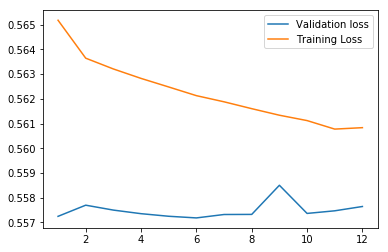

In [84]:
score = model.evaluate(X_cv, Y_cv, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])
vy = hist.history['val_loss']
ty = hist.history['loss']
x = list(range(1,epoch+1))
plt.plot(x,vy,label = 'Validation loss')
plt.plot(x,ty,label="Training Loss")
plt.legend()
plt.show()

In [95]:
ou_dim=2
input_dim = 3072
batch_size = 500
epoch = 25

In [96]:
model = Sequential()
model.add(Dense(3000,activation='sigmoid',input_shape=(input_dim,)))
model.add(BatchNormalization())
model.add(Dense(2000,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1500,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1000,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(240,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(120,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(10,activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dense(ou_dim,activation = 'softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 3000)              9219000   
_________________________________________________________________
batch_normalization_22 (Batc (None, 3000)              12000     
_________________________________________________________________
dense_58 (Dense)             (None, 2000)              6002000   
_________________________________________________________________
batch_normalization_23 (Batc (None, 2000)              8000      
_________________________________________________________________
dense_59 (Dense)             (None, 1500)              3001500   
_________________________________________________________________
batch_normalization_24 (Batc (None, 1500)              6000      
_________________________________________________________________
dense_60 (Dense)             (None, 1000)              1501000   
__________

In [97]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(np.asarray(X_tr), Y_train, batch_size=batch_size, epochs=epoch, verbose=1, validation_data=(np.asarray(X_test), Y_test))

Train on 11200 samples, validate on 3500 samples
Epoch 1/25
11200/11200 [==============================] - 7s 627us/step - loss: 0.7759 - acc: 0.5078 - val_loss: 0.7866 - val_acc: 0.2871
Epoch 2/25
11200/11200 [==============================] - 4s 335us/step - loss: 0.6966 - acc: 0.5910 - val_loss: 0.6257 - val_acc: 0.7551
Epoch 3/25
11200/11200 [==============================] - 4s 340us/step - loss: 0.6659 - acc: 0.6762 - val_loss: 0.6484 - val_acc: 0.7543
Epoch 4/25
11200/11200 [==============================] - 4s 334us/step - loss: 0.6295 - acc: 0.7244 - val_loss: 0.6929 - val_acc: 0.7531
Epoch 5/25
11200/11200 [==============================] - 4s 338us/step - loss: 0.6207 - acc: 0.7289 - val_loss: 0.5803 - val_acc: 0.7537
Epoch 6/25
11200/11200 [==============================] - 4s 337us/step - loss: 0.6033 - acc: 0.7321 - val_loss: 1.2536 - val_acc: 0.2454
Epoch 7/25
11200/11200 [==============================] - 4s 342us/step - loss: 0.5940 - acc: 0.7420 - val_loss: 0.8385 - v

Test score: 0.8672361619131905
Test accuracy: 0.7567857142857143


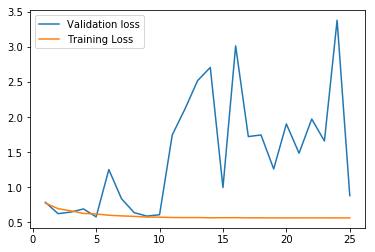

In [98]:
score = model.evaluate(X_cv, Y_cv, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])
vy = hist.history['val_loss']
ty = hist.history['loss']
x = list(range(1,epoch+1))
plt.plot(x,vy,label = 'Validation loss')
plt.plot(x,ty,label="Training Loss")
plt.legend()
plt.show()

In [99]:
model = Sequential()
model.add(Dense(4000,activation='sigmoid',input_shape=(input_dim,)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(2000,activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(1500,activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(1000,activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(240,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(120,activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(10,activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dense(ou_dim,activation = 'softmax'))
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 4000)              12292000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4000)              0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 4000)              16000     
_________________________________________________________________
dense_66 (Dense)             (None, 2000)              8002000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2000)              0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 2000)              8000      
___________________________

In [100]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(np.asarray(X_tr), Y_train, batch_size=batch_size, epochs=epoch, verbose=1, validation_data=(np.asarray(X_test), Y_test))

Train on 11200 samples, validate on 3500 samples
Epoch 1/25
11200/11200 [==============================] - 9s 779us/step - loss: 0.8482 - acc: 0.5194 - val_loss: 0.6209 - val_acc: 0.7320
Epoch 2/25
11200/11200 [==============================] - 5s 432us/step - loss: 0.7740 - acc: 0.5461 - val_loss: 0.5855 - val_acc: 0.7523
Epoch 3/25
11200/11200 [==============================] - 5s 431us/step - loss: 0.7199 - acc: 0.5768 - val_loss: 0.5906 - val_acc: 0.7529
Epoch 4/25
11200/11200 [==============================] - 5s 431us/step - loss: 0.6831 - acc: 0.6085 - val_loss: 0.6206 - val_acc: 0.7540
Epoch 5/25
11200/11200 [==============================] - 5s 436us/step - loss: 0.6661 - acc: 0.6301 - val_loss: 0.5791 - val_acc: 0.7546
Epoch 6/25
11200/11200 [==============================] - 5s 424us/step - loss: 0.6533 - acc: 0.6404 - val_loss: 0.5641 - val_acc: 0.7546
Epoch 7/25
11200/11200 [==============================] - 5s 449us/step - loss: 0.6289 - acc: 0.6717 - val_loss: 0.5729 - v

Test score: 0.555279780796596
Test accuracy: 0.7567857142857143


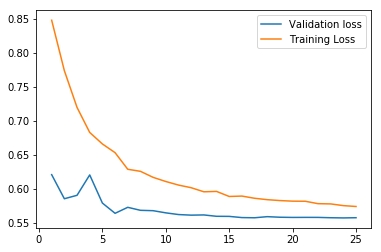

In [101]:
score = model.evaluate(X_cv, Y_cv, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])
vy = hist.history['val_loss']
ty = hist.history['loss']
x = list(range(1,epoch+1))
plt.plot(x,vy,label = 'Validation loss')
plt.plot(x,ty,label="Training Loss")
plt.legend()
plt.show()

In [102]:
ou_dim=2
input_dim = 3072
batch_size = 1000
epoch = 25

In [104]:
model = Sequential()
model.add(Dense(4000,activation='relu',input_shape=(input_dim,),kernel_initializer=RandomNormal(mean=0.0, stddev=0.039, seed=None)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(2000,activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.039, seed=None)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(1500,activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.039, seed=None)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(1000,activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.039, seed=None)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(240,activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.039, seed=None)))
model.add(BatchNormalization())
model.add(Dense(120,activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.039, seed=None)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(10,activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.039, seed=None)))
model.add(BatchNormalization())
model.add(Dense(ou_dim,activation = 'softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 4000)              12292000  
_________________________________________________________________
dropout_7 (Dropout)          (None, 4000)              0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 4000)              16000     
_________________________________________________________________
dense_76 (Dense)             (None, 2000)              8002000   
_________________________________________________________________
dropout_8 (Dropout)          (None, 2000)              0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 2000)              8000      
_________________________________________________________________
dense_77 (Dense)             (None, 1500)              3001500   
__________

In [105]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(np.asarray(X_tr), Y_train, batch_size=batch_size, epochs=epoch, verbose=1, validation_data=(np.asarray(X_test), Y_test))

Train on 11200 samples, validate on 3500 samples
Epoch 1/25
11200/11200 [==============================] - 10s 908us/step - loss: 0.8686 - acc: 0.4512 - val_loss: 2.4188 - val_acc: 0.6120
Epoch 2/25
11200/11200 [==============================] - 5s 454us/step - loss: 0.7270 - acc: 0.4920 - val_loss: 1.2297 - val_acc: 0.7446
Epoch 3/25
11200/11200 [==============================] - 5s 456us/step - loss: 0.6827 - acc: 0.5508 - val_loss: 0.5859 - val_acc: 0.7546
Epoch 4/25
11200/11200 [==============================] - 5s 454us/step - loss: 0.6562 - acc: 0.6251 - val_loss: 0.6162 - val_acc: 0.7431
Epoch 5/25
11200/11200 [==============================] - 5s 452us/step - loss: 0.6381 - acc: 0.6955 - val_loss: 0.5974 - val_acc: 0.7509
Epoch 6/25
11200/11200 [==============================] - 5s 453us/step - loss: 0.6274 - acc: 0.7251 - val_loss: 0.5780 - val_acc: 0.7546
Epoch 7/25
11200/11200 [==============================] - 5s 454us/step - loss: 0.6166 - acc: 0.7436 - val_loss: 0.5776 - 

Test score: 0.557692893913814
Test accuracy: 0.7567857142857143


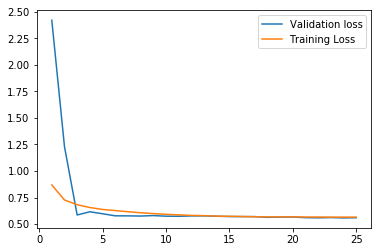

In [106]:
score = model.evaluate(X_cv, Y_cv, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])
vy = hist.history['val_loss']
ty = hist.history['loss']
x = list(range(1,epoch+1))
plt.plot(x,vy,label = 'Validation loss')
plt.plot(x,ty,label="Training Loss")
plt.legend()
plt.show()

# CNN(Convolutional Nerral Network)

### Le net

In [33]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import sys

In [48]:
x_1, x_test, y_1, y_test = cross_validation.train_test_split(imgs_train,train_labels, test_size=0.2, random_state=0)
print(x_1.shape,x_test.shape)

(14000, 32, 32, 3) (3500, 32, 32, 3)


In [49]:
x_1 = x_1.reshape(14000,3,32,32)
x_test = x_test.reshape(3500,3,32,32)
print(x_1.shape,x_test.shape)

(14000, 3, 32, 32) (3500, 3, 32, 32)


In [55]:
Y_train = np_utils.to_categorical(y_1, 2) 
Y_test = np_utils.to_categorical(y_test,2)

In [89]:
class Lenet():
    def build(self,width,height,depth,classes):
        model=Sequential()
        model.add(Conv2D(20,(5,5),border_mode = "Same",input_shape = (depth,height,width)))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="Same"))
        model.add(Dropout(0.7))
        model.add(Conv2D(50,5,5,border_mode = "Same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="Same"))
        model.add(Dropout(0.5))
        
        model.add(Flatten())
        model.add(Dense(10000))
        model.add(Activation("relu"))
        model.add(Dense(1000))
        model.add(Activation("relu"))
        model.add(Dense(100))
        model.add(Activation('relu'))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        return model
model1= Lenet()
model1 = model1.build(32,32,3,2)
        

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(20, (5, 5), padding="Same", input_shape=(3, 32, 32...)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (5, 5), padding="Same")`
  


In [90]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 3, 32, 20)         16020     
_________________________________________________________________
activation_72 (Activation)   (None, 3, 32, 20)         0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 2, 16, 20)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2, 16, 20)         0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 2, 16, 50)         25050     
_________________________________________________________________
activation_73 (Activation)   (None, 2, 16, 50)         0         
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 1, 8, 50)          0         
__________

In [91]:
model1.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [92]:
model1.fit(x_1,Y_train,
          epochs= 20,
          batch_size = 1000,
          validation_data = (x_test,Y_test))

Train on 14000 samples, validate on 3500 samples
Epoch 1/20
14000/14000 [==============================] - 6s 419us/step - loss: 3.9905 - acc: 0.7391 - val_loss: 3.9343 - val_acc: 0.7546
Epoch 2/20
14000/14000 [==============================] - 5s 359us/step - loss: 4.0133 - acc: 0.7496 - val_loss: 3.9343 - val_acc: 0.7546
Epoch 3/20
14000/14000 [==============================] - 5s 373us/step - loss: 4.0133 - acc: 0.7496 - val_loss: 3.9343 - val_acc: 0.7546
Epoch 4/20
14000/14000 [==============================] - 5s 375us/step - loss: 4.0133 - acc: 0.7496 - val_loss: 3.9343 - val_acc: 0.7546
Epoch 5/20
14000/14000 [==============================] - 5s 390us/step - loss: 4.0133 - acc: 0.7496 - val_loss: 3.9343 - val_acc: 0.7546
Epoch 6/20
14000/14000 [==============================] - 7s 479us/step - loss: 4.0133 - acc: 0.7496 - val_loss: 3.9343 - val_acc: 0.7546
Epoch 7/20
14000/14000 [==============================] - 7s 525us/step - loss: 4.0133 - acc: 0.7496 - val_loss: 3.9343 - v

After experimenting with the layers i have seen no improvement in my models and loss is not
getting reduced furthur so now i will try using Transfer Learning 

### Transfer Learning